# Causal Effect Variational Autoencoder Example

## Outline

TODO

[Setup](#setup)

[Overview: Systematically adjusting for observed confounding](#overview-systematically-adjusting-for-observed-confounding)
- [Task: Treatment effect estimation with observational data](#task-treatment-effect-estimation-with-observational-data)
- [Challenge: Confounding](#challenge-confounding)
- [Assumptions: All latent confounders influence at least one "proxy" covariate](#assumptions-all-latent-confounders-influence-at-least-one-proxy-covariate)
- [Intuition: Adjusting for confounding via proxies](#intuition-adjusting-for-confounding-via-proxies)

[Example: Evaluating the impact of a job training program](#example-evaluating-the-impact-of-a-job-training-program)
- [Variables](#variables)
- [Motivation](#motivation)
- [Source](#source)

[Causal Probabilistic Program](#causal-probabilistic-program)
- [Model Description](#model-description)
- [Prior Description](#prior-description)
- [Informal Prior Predictive Check: Visualizing Samples](#informal-prior-predictive-check---visualizing-samples)

[Causal Query: average treatment effect](#causal-query-average-treatment-effect-ate)

[Causal Inference as Probabilistic Inference](#causal-inference-as-probabilistic-inference)
- [Maximum Likelihood Inference](#maximum-likelihood-inference)
- [Maximum a Posteriori Inference](#maximum-a-posteriori-inference)

[Results](#results)


## Setup

Here, we install the necessary Pytorch, Pyro, and Causal Pyro dependencies for this example.

In [28]:
# TODO trim this down to just the CEVAE example.

from typing import Callable, Dict, List, Optional, Tuple, Union, TypeVar

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.infer.util import torch_item
from pyro.nn import PyroModule, PyroSample, PyroParam
from pyro.contrib.autoname import scope
from pyro.poutine import condition, reparam
from pyro.optim import ClippedAdam
from pyro.util import torch_isnan

import causal_pyro
from causal_pyro.query.do_messenger import do
from causal_pyro.counterfactual.handlers import Factual, MultiWorldCounterfactual, TwinWorldCounterfactual


## Overview: Proxy variables and latent confounders

### **Task:** Treatment effect estimation with observational data

Just as in the [backdoor](backdoor.ipynb) and [slc](slc.ipynb) examples, in this example we are interested in estimating how changes (or interventions) to a particular treatment variable $T$ influence a particular outcome variable $Y$. We wish to estimate this causal effect using *observational* (non-randomized) data from $T$, $Y$, and some collection of covariates $X =\{X_1, ..., X_d\}$.

### **Challenge:** Confounding

As the task here is exactly identical to the [backdoor](backdoor.ipynb) and [slc](slc.ipynb) examples, so too are the challenges. From the [backdoor](backdoor.ipynb) example: 

"Unfortunately, naively estimating the effect of an intervention by simply approximating $P(Y|T)$ alone may produce poor estimates of $T$'s effect on $Y$."

Note: While the challenges remain the same between these examples, the assumptions we make will differ substantially.

### **Assumptions:** All latent confounders influence at least one "proxy" covariate

In the [backdoor](backdoor.ipynb) example we saw how to estimate causal effects from observational data when all confounders were observed. In the [slc](slc.ipynb) example we softened this assumption, instead allowing some latent confounders to be shared between instances (e.g. students) belonging to the same object (e.g. school). In this example we again soften the restrictive assumptions made in the [backdoor](backdoor.ipynb) example, however using a different assumption about the relationship between potential latent confounders $Z$ and data $T$, $Y$, and $X$.

Specifically, in this example we assume that every latent confounder $Z_i \in Z$ is a cause of at least one "proxy" covariate $X_j \in X$. See Figure 1 in Louizos et al. [louizos2017causal] for a graphical description of these assumptions.

Importantly, in this work we do not wish to make strong parameteric assumptions (e.g. linear structural functions) relating latent confounders, proxy covariates, treatment, and outcome. As we'll see later, we can instead approximate these local causal dependencies using probabilistic models with neural network components.

**Note:** In the original paper introducing the CEVAE model [louizos2017causal], the authors prove a theorem (Theorem 1) stating that the conditional average treatment effect is identifiable if the model is correctly specified, including a strong assumption about the marginal distribution over latent confounders $Z$. Recent work [rissanen2021critical] has investigated the consequences of misspecifying components of the CEVAE model, concluding that its derived causal estimate are in fact sensitive to these detailed assumptions about the generative model. While some more restrictive settings may yield more robust identification results or bounds on causal effects (e.g. binary variables [kuroki2014measurement]), to the best of our knowledge little more is known about the nonparametric or semiparametric settings.

Rissanen, Severi, and Pekka Marttinen. "A critical look at the consistency of causal estimation with deep latent variable models." Advances in Neural Information Processing Systems 34 (2021): 4207-4217.

Kuroki, Manabu, and Judea Pearl. "Measurement bias and effect restoration in causal inference." Biometrika 101.2 (2014): 423-437.

### **Intuition:** Adjusting for confounding via proxies

In the [backdoor](backdoor.ipynb) tutorial we discussed how to estiamte causal effects with observational data by partitioning individual units into nonoverlapping subgroups such that each subgroup had similar or identical values of observed covariates $X$. When all confounders are observed, "adjusting for" confounders in this way produces unbiased estimates of the population-level causal effects we are interested in. However, this is not the case when some confounders are latent.

In this example we have made an additional assumption that all latent confounders causally influence at least one observed covariate, which we call "proxy confounders". Imagine for moment a scenario where this causal relationship is deterministic, bijective, and smooth. In this idealized scenario partitioning groups of individuals based on observed covariates $X$ produces groups that are equivalent to those we would have produced if the latent confounders $Z$ were in fact observed. This is true even though we don't know the true assignments of $Z$ for our observed data; as every subgroup will have similar values by construction. 

In practice, the relationship between latent confounders and observed covariates never satisfies this idealized deterministic property. Instead, the CEVAE model includes an explicitly probabilistic relationship between latent confounders and observed covariates, using neural network components. With the previous caveat about identifiability and robustness of the CEVAE model aside, we can intuit that conditioning on these proxy confounders will update our posterior beliefs about which latent confounders are similar to each other, albiet without absolute certainty.

## Example: Synthetic Data

In [29]:
num_train, num_test = 10000, 2000
feature_dim = 10
z_gap = 1.
y_gap = 3.

def generate_data(num_data, feature_dim, z_gap, y_gap):

    z = dist.Bernoulli(0.5).sample([num_data])
    x = dist.Normal(z * z_gap, 5 * z + 3 * (1 - z)).sample([feature_dim]).t()
    t = dist.Bernoulli(0.75 * z + 0.25 * (1 - z)).sample()
    y = dist.Bernoulli(logits=y_gap * (z + 2 * (2 * t - 1))).sample()

    # Compute true ite for evaluation (via Monte Carlo approximation).
    t0_t1 = torch.tensor([[0.0], [1.0]])
    y_t0, y_t1 = dist.Bernoulli(logits=y_gap * (z + 2 * (2 * t0_t1 - 1))).mean
    true_ite = y_t1 - y_t0
    return x, t, y, true_ite


x, t, y, _ = generate_data(num_train, feature_dim, z_gap, y_gap)
x_test, _, _, true_ite = generate_data(num_test, feature_dim, z_gap, y_gap)

## Model: neural surrogate causal Bayesian network

Our model captures the intuition that our three observed variables, $X$,
$t$, and $y$, may be correlated, thanks to unobserved confounders $z$.
Here, $f$, $g$, and $h$ are neural networks parameterized by different
parts of the parameter set $\theta$. The parameters of our model can be fit
using standard techniques in Pyro (e.g., stochastic variational
inference).

In [30]:
class FullyConnected(nn.Sequential):
    def __init__(self, sizes):
        layers = []
        for in_size, out_size in zip(sizes, sizes[1:]):
            layers.append(nn.Linear(in_size, out_size))
            layers.append(nn.ELU())
        layers.pop(-1)
        super().__init__(*layers)


class DiagNormalNet(FullyConnected):
    def __init__(self, sizes):
        assert len(sizes) >= 2
        sizes = sizes[:-1] + [sizes[-1] * 2]
        super().__init__(sizes)

    def forward(self, x):
        loc, scale = super().forward(x).chunk(2, dim=-1)
        return loc, nn.functional.softplus(scale)


class BernoulliNet(FullyConnected):
    def __init__(self, sizes):
        super().__init__(sizes + [1])

    def forward(self, x):
        return super().forward(x).squeeze(-1).clamp(min=-10, max=10)


class PreWhitener(nn.Module):
    """
    Data pre-whitener.
    """
    def __init__(self, data):
        super().__init__()
        with torch.no_grad():
            loc = data.mean(0)
            scale = data.std(0)
            scale[~(scale > 0)] = 1.0
            self.register_buffer("loc", loc)
            self.register_buffer("inv_scale", scale.reciprocal())

    def forward(self, data):
        return (data - self.loc) * self.inv_scale

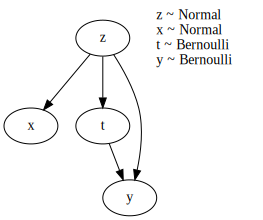

In [31]:
class ProxyConfounderModel(PyroModule):
    """
    :param dict config: A dict specifying ``feature_dim``, ``latent_dim``,
        ``hidden_dim``, ``num_layers``, and ``outcome_dist``.
    """

    def __init__(self, feature_dim: int, latent_dim: int, hidden_dim: int, num_layers: int):
        super().__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.feature_dim = feature_dim
        self.x_nn = DiagNormalNet([latent_dim] + [hidden_dim] * num_layers + [feature_dim])
        self.t_nn = BernoulliNet([latent_dim])
        # The y network is split between the two t values.
        self.y0_nn = BernoulliNet([latent_dim] + [hidden_dim] * num_layers)
        self.y1_nn = BernoulliNet([latent_dim] + [hidden_dim] * num_layers)

    def forward(self):
        z = pyro.sample("z", dist.Normal(0, 1).expand([self.latent_dim]).to_event(1))
        x = pyro.sample("x", dist.Normal(*self.x_nn(z)).to_event(1))
        t = pyro.sample("t", dist.Bernoulli(logits=self.t_nn(z)))
        # parameters are not shared among values of t
        y_logits = torch.where(t == 1, self.y1_nn(z), self.y0_nn(z))
        y = pyro.sample("y", dist.Bernoulli(logits=y_logits))
        return y


individual_model = ProxyConfounderModel(
    feature_dim=x.shape[-1],
    latent_dim=5,
    hidden_dim=200,
    num_layers=3,
)
pyro.render_model(individual_model, model_args=(), render_distributions=True)

## Query: conditional average treatment effect (CATE)

We can now set up a larger model in which the *conditional average
treatment effect* (CATE) we want to estimate is a random variable.

### Fit parameters via maximum likelihood

Before estimating the query, we fit deterministic parameters in the model to the observed data using maximum likelihood.

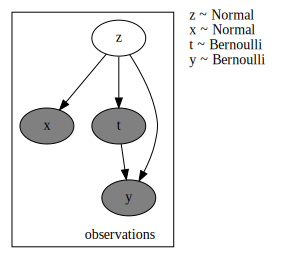

In [32]:
class CEVAE_MLE(PyroModule):
    def __init__(self, individual_model: ProxyConfounderModel):
        super().__init__()
        self.individual_model = individual_model

    def forward(self, x_obs, t_obs, y_obs):
        with pyro.condition(data=dict(x=x_obs, t=t_obs, y=y_obs)), \
                pyro.plate("observations", size=x_obs.shape[0], dim=-1):
            return self.individual_model()


mle_model = CEVAE_MLE(individual_model)
pyro.render_model(mle_model, model_args=(x, t ,y), render_distributions=True)

In [33]:
pyro.clear_param_store()
num_iterations = 2500 
batch_size = 100 
learning_rate = 1e-3 
learning_rate_decay = 0.1 
weight_decay = 1e-4
jit = False 

x_data = x.clone().detach()
t_data = t.clone().detach()
y_data = y.clone().detach()

mle_guide = pyro.infer.autoguide.AutoNormal(mle_model)
adam = pyro.optim.Adam({"lr": learning_rate, "weight_decay": weight_decay})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(mle_model, mle_guide, adam, elbo)

for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, t_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x_data)))


[iteration 0001] loss: 201.1257
[iteration 0101] loss: 37.6086
[iteration 0201] loss: 36.4760
[iteration 0301] loss: 35.9275
[iteration 0401] loss: 35.4894
[iteration 0501] loss: 35.0151
[iteration 0601] loss: 34.5830
[iteration 0701] loss: 34.0057
[iteration 0801] loss: 33.4215
[iteration 0901] loss: 32.9623
[iteration 1001] loss: 32.5413
[iteration 1101] loss: 32.1159
[iteration 1201] loss: 31.7622
[iteration 1301] loss: 31.4344
[iteration 1401] loss: 31.1369
[iteration 1501] loss: 30.8730
[iteration 1601] loss: 30.6359
[iteration 1701] loss: 30.4342
[iteration 1801] loss: 30.2793
[iteration 1901] loss: 30.1098
[iteration 2001] loss: 29.9815
[iteration 2101] loss: 29.8572
[iteration 2201] loss: 29.7646
[iteration 2301] loss: 29.6712
[iteration 2401] loss: 29.6067


Now we can set up the extended model corresponding to the CATE:

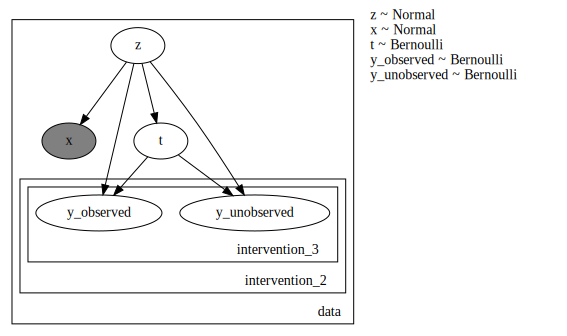

In [34]:
class CEVAE_CATE(PyroModule):
    def __init__(self, individual_model: ProxyConfounderModel):
        super().__init__()
        self.individual_model = individual_model

    def forward(self, x_pred):
        extended_model = do(actions = {"t": 0})(
                            do(actions = {"t": 1})(
                                pyro.plate("data", size=x_pred.shape[0], dim=-1)(
                                    condition(data=dict(x=x_pred))(self.individual_model))))
        with MultiWorldCounterfactual(-2):
            Ys_pred = extended_model()

        return Ys_pred


cate_model = CEVAE_CATE(individual_model)
pyro.render_model(cate_model, model_args=(x,), render_distributions=True)


## Inference

The CATE is the expected return value of this new model, conditioning on
the observed covariates $X$. Any inference method available in Pyro
could be used to estimate it, including amortized variational inference
[@kingma2013auto] as in the original paper [@louizos2017causal].

In [35]:
pyro.clear_param_store()
num_iterations = 2500 
x_pred_data = x_test.clone().detach()
whiten = PreWhitener(x_pred_data)

cate_model_fit = pyro.poutine.block(hide_types=["param",])(
    pyro.infer.config_enumerate(cate_model))
cate_guide = pyro.infer.autoguide.AutoNormal(pyro.poutine.block(cate_model_fit, hide=['t', 'y_observed', 'y_unobserved']))
elbo = pyro.infer.TraceEnum_ELBO()

adam = pyro.optim.Adam({"lr": learning_rate, "weight_decay": weight_decay})
svi = pyro.infer.SVI(cate_model_fit, cate_guide, adam, elbo)

for j in range(num_iterations):
    # calculate the loss and take a gradient step
    x_data = whiten(x_pred_data)
    loss = svi.step(x_pred_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x_pred_data)))

[iteration 0001] loss: 38.6423
[iteration 0101] loss: 37.1858
[iteration 0201] loss: 36.0536
[iteration 0301] loss: 35.0830
[iteration 0401] loss: 34.2780
[iteration 0501] loss: 33.5433
[iteration 0601] loss: 32.9577
[iteration 0701] loss: 32.3645
[iteration 0801] loss: 31.8925
[iteration 0901] loss: 31.4478
[iteration 1001] loss: 31.0481
[iteration 1101] loss: 30.6879
[iteration 1201] loss: 30.3822
[iteration 1301] loss: 30.0536
[iteration 1401] loss: 29.8035
[iteration 1501] loss: 29.6169
[iteration 1601] loss: 29.4158
[iteration 1701] loss: 29.2283
[iteration 1801] loss: 29.0620
[iteration 1901] loss: 28.9846
[iteration 2001] loss: 28.9081
[iteration 2101] loss: 28.8158
[iteration 2201] loss: 28.7886
[iteration 2301] loss: 28.7023
[iteration 2401] loss: 28.6836


## Evaluation

In [36]:
predictive = pyro.infer.Predictive(cate_model, guide=cate_guide, num_samples=100, return_sites=("t", "x", "z", "y_unobserved",))
preds = predictive(x_pred_data)
ys_pred, t_pred, zs_pred = preds["y_unobserved"], preds["t"], preds["z"]

est_ites = ys_pred[..., 1, 0, :] - ys_pred[..., 0, 1, :]

cate = est_ites.mean(0)
true_ate = true_ite.mean()
est_ate = est_ites.mean(-1)

mae_ate = torch.abs(true_ite - est_ites).mean()

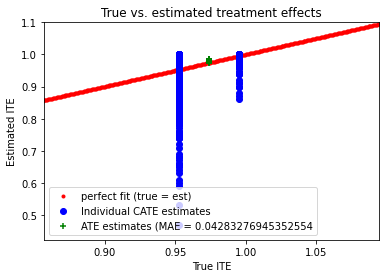

In [37]:
xmin, xmax = 0.9 * true_ite.min().item(), 1.1 * true_ite.max().item()
ymin, ymax = 0.9 * cate.min().item(), 1.1 * cate.max().item()
diag = torch.linspace(min(xmin, ymin), max(xmax, ymax), 1000)
plt.scatter(diag.detach().cpu().numpy(), diag.detach().cpu().numpy(), color='red', marker='.', label='perfect fit (true = est)')
plt.scatter(true_ite.detach().cpu().numpy(), cate.detach().cpu().numpy(), color='blue', label='Individual CATE estimates')
plt.scatter(true_ate.expand(est_ate.shape).detach().cpu().numpy(), est_ate.detach().cpu().numpy(), color='green', marker='+', label=f'ATE estimates (MAE = {mae_ate}')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.xlabel('True ITE')
plt.ylabel('Estimated ITE')
plt.title('True vs. estimated treatment effects')
plt.legend()

Text(0.5, 1.0, 'Individual CATE estimates (mean = 0.9813401103019714)')

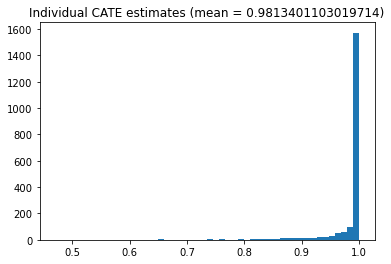

In [38]:
plt.hist(cate.detach().cpu().numpy(), bins=50)
plt.title(f'Individual CATE estimates (mean = {cate.mean().item()})')